In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

torch.manual_seed(42)
np.random.seed(42)


In [3]:
def load_fence_data(file_paths, input_dim=9):
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file)
        # Ensure columns "0", "1", ..., "N-1" exist else pad with 0.
        panel_cols = [str(i) for i in range(input_dim)]
        for col in panel_cols:
            if col not in df.columns:
                df[col] = 0.0
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    
    X = data[panel_cols].values.astype(np.float32)
    perimeters = np.sum(X, axis=1, keepdims=True) + 1e-8
    X = X / perimeters  # Normalize panel lengths to be relative.
    
    y = data['CE'].values.astype(np.float32)
    return X, y

def load_test_data(file_path, input_dim=9):

    df = pd.read_csv(file_path)
    panel_cols = [str(i) for i in range(input_dim)]
    for col in panel_cols:
        if col not in df.columns:
            df[col] = 0.0
    X = df[panel_cols].values.astype(np.float32)
    perimeters = np.sum(X, axis=1, keepdims=True) + 1e-8
    X = X / perimeters
    test_ids = df['id'].values
    return torch.tensor(X), test_ids

train_files = ["data/kaggle_train_5_fences.csv",
               "data/kaggle_train_7_fences.csv",
               "data/kaggle_train_9_fences.csv"]

X_train, y_train = load_fence_data(train_files, input_dim=9)
print("Combined training data shapes: X =", X_train.shape, "y =", y_train.shape)


Combined training data shapes: X = (15000, 9) y = (15000,)


In [12]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8
0,0.121168,0.015888,0.447253,0.177705,0.237987,0.000000,0.000000,0.000000,0.000000
1,0.064785,0.066641,0.111723,0.482004,0.274846,0.000000,0.000000,0.000000,0.000000
2,0.363049,0.156856,0.027072,0.165332,0.287690,0.000000,0.000000,0.000000,0.000000
3,0.311401,0.061350,0.152501,0.140736,0.334011,0.000000,0.000000,0.000000,0.000000
4,0.047276,0.437467,0.396640,0.049635,0.068983,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
14995,0.009687,0.126779,0.013325,0.011328,0.286315,0.036754,0.363581,0.038718,0.113514
14996,0.000524,0.187674,0.099238,0.027425,0.082273,0.264654,0.207503,0.120204,0.010505
14997,0.240975,0.048082,0.105216,0.033052,0.292867,0.013061,0.053886,0.200642,0.012221
14998,0.059000,0.099512,0.095119,0.068827,0.030551,0.012886,0.115610,0.147674,0.370822


In [4]:
class FenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)  # (num_samples, 9)
        self.y = torch.tensor(y).unsqueeze(1)  # (num_samples, 1)
    
    def __len__(self):
        return self.X.size(0)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and dataloader for training data
dataset = FenceDataset(X_train, y_train)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [10]:
loader

In [5]:
class DeepSetsModel(nn.Module):
    def __init__(self, input_dim=9, phi_hidden=64, rho_hidden1=128, rho_hidden2=64, rho_hidden3=32):

        super(DeepSetsModel, self).__init__()
        self.input_dim = input_dim
        
        # PHI network
        self.phi_fc1 = nn.Linear(1, phi_hidden)
        self.phi_fc2 = nn.Linear(phi_hidden, phi_hidden)
        
        # RHO network
        self.rho_fc1 = nn.Linear(phi_hidden, rho_hidden1)
        self.rho_fc2 = nn.Linear(rho_hidden1, rho_hidden2)
        self.rho_fc3 = nn.Linear(rho_hidden2, rho_hidden3)
        self.out = nn.Linear(rho_hidden3, 1)
        
    def forward(self, panels):

        batch_size = panels.size(0)
        # Create a mask: 1 if panel > 0, else 0.
        mask = (panels > 0).float() 
        
        # Expand panels to shape (batch_size, input_dim, 1)
        x = panels.unsqueeze(-1) 
        # Flatten to (batch_size * input_dim, 1) for processing each panel independently.
        x = x.reshape(-1, 1)
        
        # PHI network
        phi_out = F.relu(self.phi_fc1(x))
        phi_out = F.relu(self.phi_fc2(phi_out))
        # Reshape back to (batch_size, input_dim, phi_hidden)
        phi_out = phi_out.reshape(batch_size, self.input_dim, -1)
        
        # Apply mask: zero out embeddings for padded panels.
        mask_expanded = mask.unsqueeze(-1)
        phi_out = phi_out * mask_expanded
        
        # Aggregate using masked average pooling: sum valid embeddings and divide by count.
        sum_phi = phi_out.sum(dim=1) 
        valid_count = mask.sum(dim=1, keepdim=True) + 1e-8 
        avg_phi = sum_phi / valid_count 
        
        # RHO network
        x = F.relu(self.rho_fc1(avg_phi))
        x = F.relu(self.rho_fc2(x))
        x = F.relu(self.rho_fc3(x))
        out = torch.sigmoid(self.out(x))
        return out

model = DeepSetsModel(input_dim=9)
print("DeepSets Model with Zero Padding:")
print(model)


DeepSets Model with Zero Padding:
DeepSetsModel(
  (phi_fc1): Linear(in_features=1, out_features=64, bias=True)
  (phi_fc2): Linear(in_features=64, out_features=64, bias=True)
  (rho_fc1): Linear(in_features=64, out_features=128, bias=True)
  (rho_fc2): Linear(in_features=128, out_features=64, bias=True)
  (rho_fc3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [6]:
def train_model(model, dataloader, num_epochs=30, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    model.train()
    
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for panels_batch, labels_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(panels_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * panels_batch.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == labels_batch).sum().item()
            total += labels_batch.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2%}")
    return model, train_losses, train_accuracies

# Train the model using our DataLoader.
print("Training the DeepSets model...")
model, train_losses, train_accuracies = train_model(model, loader, num_epochs=30, lr=0.001)


Training the DeepSets model...
Epoch 1/30 - Loss: 0.4714, Accuracy: 73.59%
Epoch 2/30 - Loss: 0.1499, Accuracy: 94.66%
Epoch 3/30 - Loss: 0.1326, Accuracy: 95.26%
Epoch 4/30 - Loss: 0.1146, Accuracy: 95.75%
Epoch 5/30 - Loss: 0.0903, Accuracy: 96.62%
Epoch 6/30 - Loss: 0.0862, Accuracy: 96.48%
Epoch 7/30 - Loss: 0.0864, Accuracy: 96.38%
Epoch 8/30 - Loss: 0.0707, Accuracy: 97.12%
Epoch 9/30 - Loss: 0.0718, Accuracy: 96.85%
Epoch 10/30 - Loss: 0.0706, Accuracy: 96.96%
Epoch 11/30 - Loss: 0.0685, Accuracy: 97.06%
Epoch 12/30 - Loss: 0.0657, Accuracy: 97.14%
Epoch 13/30 - Loss: 0.0710, Accuracy: 96.90%
Epoch 14/30 - Loss: 0.0575, Accuracy: 97.59%
Epoch 15/30 - Loss: 0.0737, Accuracy: 97.07%
Epoch 16/30 - Loss: 0.0677, Accuracy: 97.01%
Epoch 17/30 - Loss: 0.0553, Accuracy: 97.57%
Epoch 18/30 - Loss: 0.0627, Accuracy: 97.39%
Epoch 19/30 - Loss: 0.0607, Accuracy: 97.34%
Epoch 20/30 - Loss: 0.0586, Accuracy: 97.40%
Epoch 21/30 - Loss: 0.0677, Accuracy: 97.23%
Epoch 22/30 - Loss: 0.0595, Accur

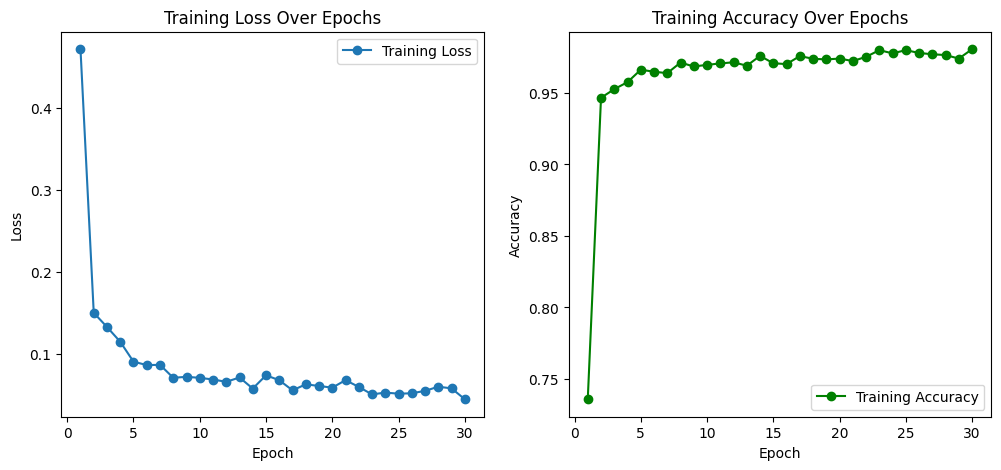

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, train_accuracies):

    epochs = range(1, len(train_losses) + 1)

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Plot Training Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", marker="o", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Over Epochs")
    plt.legend()

    # Show the plots
    plt.show()

# Example usage (assuming the lists were tracked during training)
plot_training_history(train_losses, train_accuracies)


In [ ]:
def find_misclassified_examples(model, dataloader):
    """
    Identifies misclassified samples from the validation set.
    """
    model.eval()
    errors = []

    with torch.no_grad():
        for panels_batch, labels_batch in dataloader:
            outputs = model(panels_batch)
            preds = (outputs >= 0.5).float()
            incorrect_indices = (preds != labels_batch).squeeze().nonzero(as_tuple=True)[0]
            
            for i in incorrect_indices:
                errors.append((panels_batch[i].cpu().numpy(), labels_batch[i].item(), preds[i].item()))
    
    return errors


# Example usage:
misclassified_samples = find_misclassified_examples(model, val_loader)

print(f"Found {len(misclassified_samples)} misclassified samples.")
for i, (panels, true_label, pred_label) in enumerate(misclassified_samples[10:30]):
    print(f"Example {i+1}:")
    print(f"  Panels: {panels}")
    print(f"  True Label: {true_label}, Predicted Label: {pred_label}")


In [8]:
def load_test_data(file_path, input_dim=9):
    df = pd.read_csv(file_path)
    panel_cols = [str(i) for i in range(input_dim)]
    # Replace NaN values with 0 in the panel columns
    df[panel_cols] = df[panel_cols].fillna(0)
    
    X = df[panel_cols].values.astype(np.float32)
    perimeters = np.sum(X, axis=1, keepdims=True) + 1e-8  # avoid division by zero
    X = X / perimeters
    test_ids = df['id'].values
    return torch.tensor(X), test_ids

# Example usage:
X_test, test_ids = load_test_data("data/kaggle_hidden_test_fences.csv", input_dim=9)
print("Test data shape:", X_test.shape)


Test data shape: torch.Size([45000, 9])


In [9]:
model.eval()
with torch.no_grad():
    outputs_test = model(X_test)
    preds_test = (outputs_test >= 0.5).float().cpu().numpy().flatten()

submission_df = pd.DataFrame({'id': test_ids, 'prediction': preds_test.astype(int)})
submission_df.to_csv("submission1.csv", index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'
